These are TODO's from the EDA section to be implemented in the present notebook.
- FEATURE: replace zipcodes with respective mean longitude and latitude
- FEATURE: area of each area could be added, along with density of panels for the given zip code 
- FEATURE: approximation of zipcode by first 2 digits 
- FEATURE: add aditional feature to mark US and non-US states

- NULLS: drop nulls 

- NORMALISATION: scaling num of panels group of features is required. Simply dividing by a constant to bring the mean of distribution closer to other features or normalising by mean could be attempted

# Table of Contents
- **[Feature extraction](#1)** 
- **[Nulls](#2)** 
- **[Normalisation](#3)** 

In [95]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [12]:
init_df = pd.read_csv('datasets/geo_solar_panels.csv')
state_accronyms = pd.read_csv('datasets/states_accro_mapping.csv', sep=';')
ref_df =  pd.read_csv('datasets/zip_code_database.csv')[['zip', 'state', 'latitude', 'longitude']]
ref_df = ref_df.merge(state_accronyms, how='left', left_on='state', right_on='Accro')  \
    [['zip', 'latitude', 'longitude', 'State']].rename(columns={'State': 'state'})

US_STATES = list(state_accronyms['State'].unique())

# Feature extraction

In [13]:
class FeatureExtractor:
    def __init__(self, long_min: pd.Series, long_max: pd.Series, lat_min: pd.Series, lat_max: pd.Series,
                 num_of_panels: pd.Series, usa_states: list[str], states_to_check: pd.Series, init_zips: pd.Series,
                 ref_df: pd.DataFrame, init_df_zip_col: str, ref_df_zip_col: str, 
                 ref_df_lat_col: str, ref_df_long_col: str
                 ):
        
        self.long_min = long_min
        self.long_max = long_max
        self.lat_min = lat_min
        self.lat_max = lat_max

        self.num_of_panels = num_of_panels
        self.usa_states = usa_states
        self.states_to_check = states_to_check
        self.init_zips = init_zips
        
        self.ref_df = ref_df
        self.init_df_zip_col = init_df_zip_col
        self.ref_df_zip_col = ref_df_zip_col
        self.ref_df_lat_col = ref_df_lat_col
        self.ref_df_long_col = ref_df_long_col

    def calc_mean_coords(self) -> tuple[pd.Series, pd.Series]:
        """Function calculates mean coordinates for a zip code"""
        lat_mean = (self.lat_max + self.lat_min) / 2
        long_mean = (self.long_max + self.long_min) / 2
        return lat_mean, long_mean

    def calc_zip_area(self) -> pd.Series:
        """The function calculates approx. area of zip code using min/max longitude and lattitude"""
        # adding small number to avoid zero area
        return abs(self.long_max - self.long_min) * abs(self.lat_max - self.lat_min) + .1
    
    def panels_density(self, zip_area: pd.Series) -> pd.Series:
        """Function calculates panels density in a zip_code based on zip_code area and number of panels for the zip_code"""
        return self.num_of_panels / zip_area
    
    def approx_zips(self) -> pd.Series:
        """Function returns a column with first 2 digits of zipcode given a columns of zipcodes"""
        return self.init_zips.astype('str').apply(lambda x: int(x[:2]))
    
    def mask_usa_states(self) -> pd.Series:
        """Function checks if states in the passed column are USA states"""
        return self.states_to_check.isin(self.usa_states)
    
    def zips_replacement(self, lat_long_zip_df: pd.DataFrame, init_df_mean_lat_col: str, init_df_mean_long_col: str) -> tuple[pd.Series, pd.Series]:
        """
        Function merged reference df to the provided df with lat and long and returns mean lat and long with the same index. 
        For zips with no records in the reference df, values are filled with mean coordinates from the original df.
        """
        local_df = lat_long_zip_df.merge(ref_df, how='left', left_on=self.init_df_zip_col, right_on=self.ref_df_zip_col)
        zip_lat = local_df[self.ref_df_lat_col].fillna(value=local_df[init_df_mean_lat_col])
        zip_long = local_df[self.ref_df_long_col].fillna(value=local_df[init_df_mean_long_col])
        return zip_lat, zip_long
    

In [14]:
extr = FeatureExtractor(
    long_min=init_df['long_min'],
    long_max=init_df['long_max'],
    lat_min=init_df['lat_min'],
    lat_max=init_df['lat_max'],
    init_zips=init_df['zip_code'],
    num_of_panels=init_df['number_of_panels_total'],
    usa_states=US_STATES,
    states_to_check=init_df['state'],
    ref_df=ref_df,
    init_df_zip_col='zip_code',
    ref_df_zip_col='zip',
    ref_df_lat_col='latitude',
    ref_df_long_col='longitude'
)

In [15]:
init_df.loc[:, 'lat_mean'], init_df.loc[:, 'long_mean'] = extr.calc_mean_coords()
init_df['zip_area'] = extr.calc_zip_area()
init_df['dens'] = extr.panels_density(zip_area=init_df['zip_area']) 
init_df['approx_zips'] = extr.approx_zips()
init_df['is_usa'] = extr.mask_usa_states()
init_df.loc[:, 'zip_lat'], init_df.loc[:, 'zip_long'] = extr.zips_replacement(lat_long_zip_df=init_df[['lat_mean', 'long_mean', 'zip_code']].copy(), 
                                                            init_df_mean_lat_col='lat_mean', 
                                                            init_df_mean_long_col='long_mean')

# Nulls

In [16]:
[init_df[col].isna().sum() for col in list(init_df)]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 19, 19, 0, 0, 0, 19, 0, 0, 0, 0]

In [17]:
init_df = init_df.dropna()

In [18]:
[init_df[col].isna().sum() for col in list(init_df)]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# Scaling

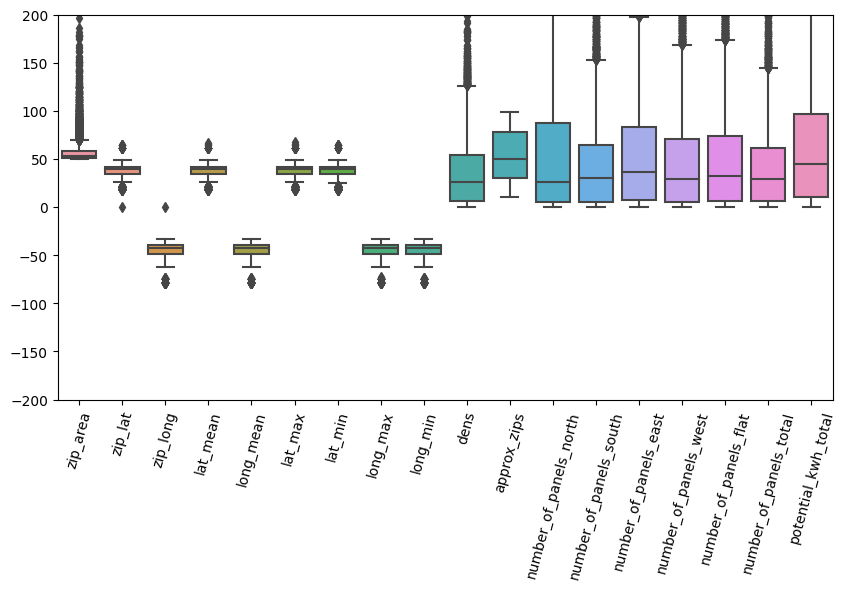

In [94]:
# We do scaling b/c linear model will be attempted to fit to data.
# Manual scaling is done here as a draft using all available data. 
# Normally scaling mults need to be found based on training data only and than applied at test time. 

feats_to_scale = ['zip_area', 'zip_lat', 'zip_long', 'lat_mean', 'long_mean', 'lat_max', 'lat_min', 'long_max', 'long_min', 'dens', 'approx_zips',
                  'number_of_panels_north', 'number_of_panels_south', 'number_of_panels_east', 'number_of_panels_west', 'number_of_panels_flat', 
                  'number_of_panels_total', 'potential_kwh_total']

mults = {
    'dens': 1e-5,
    'zip_area': 5e2,
    'zip_long': .5,
    'long_mean': .5,
    'number_of_panels_north': 3e-3,
    'number_of_panels_south': 5e-4,
    'number_of_panels_east': 1e-3,
    'number_of_panels_west': 7e-4,
    'number_of_panels_flat': 3e-4,
    'number_of_panels_total': 1e-4,
    'potential_kwh_total': 5e-7,
    'long_min': .5,
    'long_max': .5
}

def apply_mults(df: pd.DataFrame, mults: dict) -> pd.DataFrame:
    local_df = df.copy()
    for k in mults:
        local_df.loc[:, k] = local_df[k] * mults[k]
    return local_df

scaled_df = apply_mults(init_df, mults)

plt.figure(figsize=[10, 5])
sns.boxplot(scaled_df[feats_to_scale])
plt.ylim(bottom=-200, top=200); plt.xticks(rotation=75);